# Data report for the immune modulation data for 2Ome modified siRNA

This dataset was sourced from https://doi.org/10.1093/nar/gkaa523. The study focuses on the rational design of 2OMe modified ASO gapmers that inhibit TLR7 sensing while potentiating TLR8 sensing. Immune activation is induced by treating HEK-TLR7 and HEK-TLR8 cells with the small molecule Requisomod (R848). The dataset containes luciferase assay data from 192 sequences. Values were collected after dosing with 100nM or 500nM of ASO. The data shared by the authors is the average of triplicates. The values are relative to the luciferase value obtained when treating only with Requisomod, set by the authors as 1 for TLR8 readouts and 100 for TLR7 readouts.

We opted to select only the values obtained after induction with a dosage 100nM of ASO, due to the wider dynamic range of the label for the TLR7 readout. 

In [1]:
from oligogym.data import DatasetDownloader
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from oligogym.features import KMersCounts
from oligogym.models import RandomForestModel
from oligogym.metrics import regression_metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Processed dataset

In [2]:
downloader = DatasetDownloader()
dataset = downloader.download("immune_modulation_TLR7")
dataset.data

,x,y,y_raw,targets,smiles,fasta
0,RNA1{m(G)[sp].m(U)[sp].m(C)[sp].m(U)[sp].m(C)[...,2.41,2.41,CDKN2B-AS1,CO[C@@H]1[C@H](OP(=O)(S)OC[C@H]2O[C@@H](n3cc(C...,GUCUCTACTGTTACCUCUGA
1,RNA1{m(U)[sp].m(U)[sp].m(A)[sp].m(A)[sp].m(A)[...,3.96,3.96,CDKN2B-AS1,CO[C@@H]1[C@H](OP(=O)(S)OC[C@H]2O[C@@H](n3ccc(...,UUAAATAATCTAGTTUGAAG
2,RNA1{m(G)[sp].m(U)[sp].m(G)[sp].m(U)[sp].m(C)[...,1.33,1.33,CDKN2B-AS1,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,GUGUCCTTCATGCTTUGGAU
3,RNA1{m(A)[sp].m(G)[sp].m(A)[sp].m(A)[sp].m(A)[...,1.96,1.96,CDKN2B-AS1,CO[C@@H]1[C@H](OP(=O)(S)OC[C@H]2O[C@@H](n3cnc4...,AGAAAGAAGCAAAGAUUCAA
4,RNA1{m(C)[sp].m(C)[sp].m(U)[sp].m(A)[sp].m(G)[...,3.58,3.58,CDKN2B-AS1,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,CCUAGAAAGAAGCAAAGAUU
...,...,...,...,...,...,...
187,RNA1{m(G)[sp].m(C)[sp].m(G)[sp].m(U)[sp].m(A)[...,1.86,1.86,LINC-PINT,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,GCGUAGTTTCTCTTCCUCCC
188,RNA1{m(U)[sp].m(G)[sp].m(G)[sp].m(C)[sp].m(G)[...,2.48,2.48,LINC-PINT,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,UGGCGTAGTTTCTCTUCCUC
189,RNA1{m(C)[sp].m(C)[sp].m(U)[sp].m(U)[sp].m(C)[...,1.45,1.45,LINC-PINT,CO[C@@H]1[C@H](OP(=O)(S)OC[C@H]2O[C@@H](n3ccc(...,CCUUCTGCTGCCAAGCCCCA
190,RNA1{m(C)[sp].m(A)[sp].m(U)[sp].m(C)[sp].m(C)[...,2.95,2.95,LINC-PINT,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,CAUCCCTTCTGCTGCCAAGC


In [3]:
dataset_tlr8 = downloader.download("immune_modulation_TLR8")
dataset_tlr8.data

,x,y,y_raw,targets,smiles,fasta
0,RNA1{m(G)[sp].m(U)[sp].m(C)[sp].m(U)[sp].m(C)[...,19.16,19.16,CDKN2B-AS1,CO[C@@H]1[C@H](OP(=O)(S)OC[C@H]2O[C@@H](n3cc(C...,GUCUCTACTGTTACCUCUGA
1,RNA1{m(U)[sp].m(U)[sp].m(A)[sp].m(A)[sp].m(A)[...,25.66,25.66,CDKN2B-AS1,CO[C@@H]1[C@H](OP(=O)(S)OC[C@H]2O[C@@H](n3ccc(...,UUAAATAATCTAGTTUGAAG
2,RNA1{m(G)[sp].m(U)[sp].m(G)[sp].m(U)[sp].m(C)[...,18.05,18.05,CDKN2B-AS1,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,GUGUCCTTCATGCTTUGGAU
3,RNA1{m(A)[sp].m(G)[sp].m(A)[sp].m(A)[sp].m(A)[...,42.99,42.99,CDKN2B-AS1,CO[C@@H]1[C@H](OP(=O)(S)OC[C@H]2O[C@@H](n3cnc4...,AGAAAGAAGCAAAGAUUCAA
4,RNA1{m(C)[sp].m(C)[sp].m(U)[sp].m(A)[sp].m(G)[...,57.20,57.20,CDKN2B-AS1,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,CCUAGAAAGAAGCAAAGAUU
...,...,...,...,...,...,...
187,RNA1{m(G)[sp].m(C)[sp].m(G)[sp].m(U)[sp].m(A)[...,27.23,27.23,LINC-PINT,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,GCGUAGTTTCTCTTCCUCCC
188,RNA1{m(U)[sp].m(G)[sp].m(G)[sp].m(C)[sp].m(G)[...,32.81,32.81,LINC-PINT,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,UGGCGTAGTTTCTCTUCCUC
189,RNA1{m(C)[sp].m(C)[sp].m(U)[sp].m(U)[sp].m(C)[...,85.57,85.57,LINC-PINT,CO[C@@H]1[C@H](OP(=O)(S)OC[C@H]2O[C@@H](n3ccc(...,CCUUCTGCTGCCAAGCCCCA
190,RNA1{m(C)[sp].m(A)[sp].m(U)[sp].m(C)[sp].m(C)[...,54.34,54.34,LINC-PINT,CO[C@@H]1[C@H](O)[C@@H](COP(=O)(S)O[C@H]2[C@@H...,CAUCCCTTCTGCTGCCAAGC


## Features statistics

In [4]:
dataset.get_helm_stats()

,avg_nt_seq_len,combined_unique_monomers,avg_GC_content,avg_G_content,avg_C_content,avg_A_content,avg_TU_content,num_duplicates
0,20.0,"[A, C, G, T, U, d, m, sp]",44.296875,19.453125,34.570312,25.598958,30.104167,0


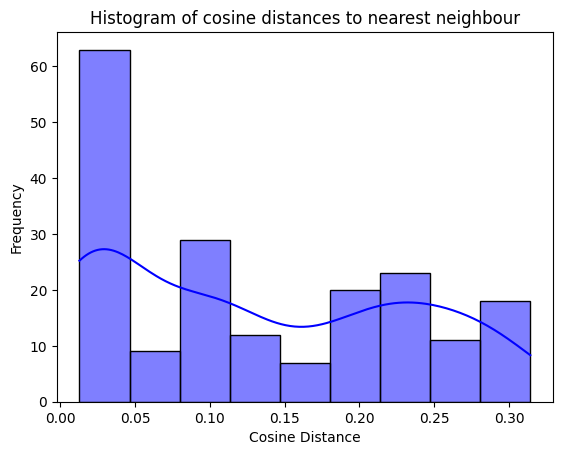

In [5]:
cosine_distances = get_cosine_dist_to_nearest_neighbor(dataset.x)

fig, ax = plt.subplots()

sns.histplot(cosine_distances, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

plt.show()

In [6]:
number_similar_sequences=np.sum(cosine_distances == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

0 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


In [7]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_random = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

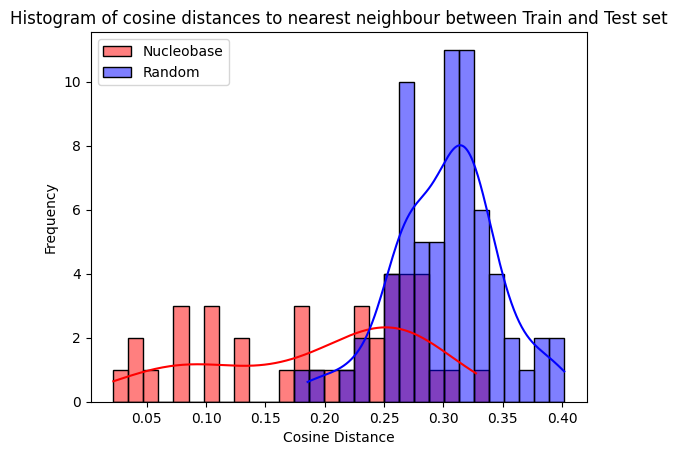

In [8]:
data_min = min(min(cosine_dist_random), min(cosine_dist_nucleobase))
data_max = max(max(cosine_dist_random), max(cosine_dist_nucleobase))

num_bins = 30
bin_edges = np.linspace(data_min, data_max, num_bins+1)

fig, ax = plt.subplots()

sns.histplot(cosine_dist_nucleobase, ax=ax, color='red', kde=True, label='Nucleobase', bins=bin_edges)
sns.histplot(cosine_dist_random, ax=ax, color='blue', kde=True, label='Random', bins=bin_edges)

ax.set_title('Histogram of cosine distances to nearest neighbour between Train and Test set')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()

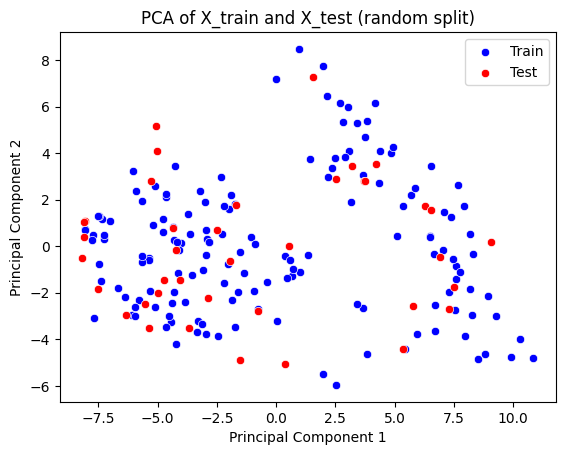

In [9]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (random split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

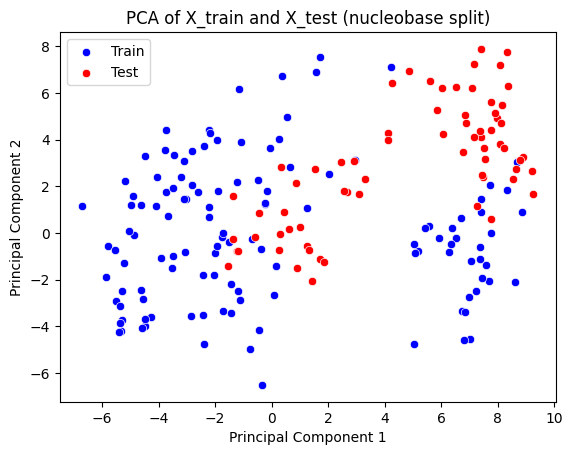

In [10]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="nucleobase", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, ax = plt.subplots()
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], ax=ax, color='blue', label='Train')
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], ax=ax, color='red', label='Test')

ax.set_title('PCA of X_train and X_test (nucleobase split)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()

plt.show()

## Labels statistics

In [11]:
dataset.get_label_stats()

,nobs,minmax,mean,variance,skewness,kurtosis,num_zeros
0,192,"(0.57, 5.44)",2.180625,1.0094,0.529895,-0.305108,0


In [12]:
dataset_tlr8.get_label_stats()

,nobs,minmax,mean,variance,skewness,kurtosis,num_zeros
0,192,"(17.46, 126.5)",49.834375,535.328188,0.953991,0.425401,0


In [13]:
print(f"{len(get_outliers(dataset.y))} datapoints are identified as outliers by IQR method")
print(f"{len(get_outliers(dataset_tlr8.y))} datapoints are identified as outliers by IQR method")

1 datapoints are identified as outliers by IQR method
3 datapoints are identified as outliers by IQR method


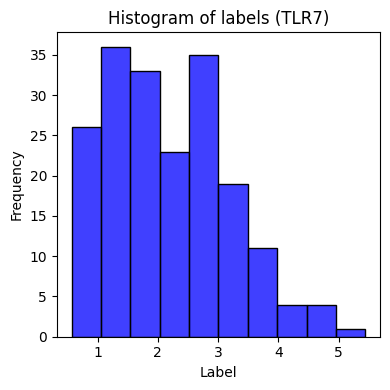

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.histplot(dataset.y, ax=ax, color='blue')
ax.set_title('Histogram of labels (TLR7)')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

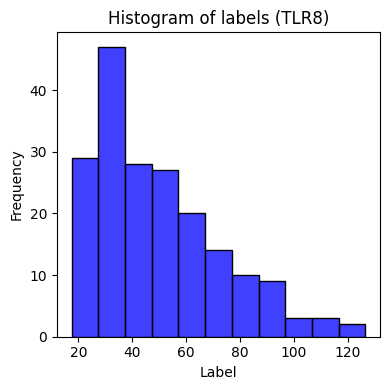

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.histplot(dataset_tlr8.y, ax=ax, color='blue')
ax.set_title('Histogram of labels (TLR8)')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Clustering analysis

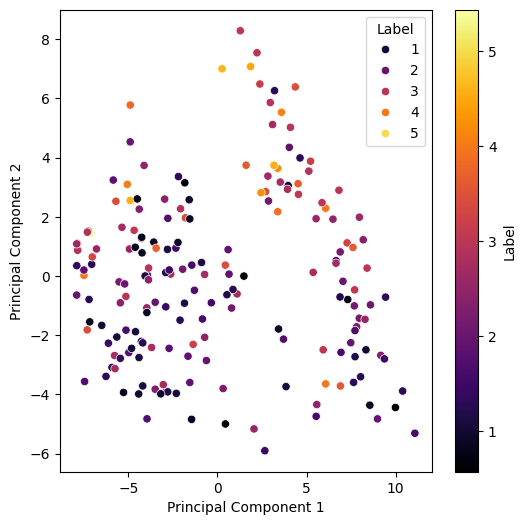

In [16]:
featurizer = KMersCounts(k=[1, 2, 3])
X_kmers = featurizer.fit_transform(dataset.x)

pca = PCA(n_components=2)
X_kmers_pca = pca.fit_transform(X_kmers)

fig, ax = plt.subplots(1 ,1, figsize=(6, 6))
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=dataset.y, ax=ax, palette='inferno')
norm = plt.Normalize(dataset.y.min(), dataset.y.max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Label')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend(title="Label")

plt.show()

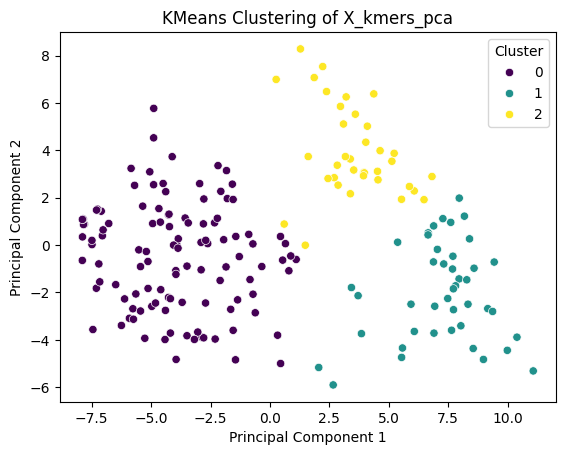

In [17]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_kmers_pca)

# Plot the clusters
fig, ax = plt.subplots()
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=clusters, palette='viridis', ax=ax)
ax.set_title('KMeans Clustering of X_kmers_pca')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Let's figure out which features differ the most between the different clusters.

In [18]:
# Calculate the mean of each feature for each cluster
cluster_means = X_kmers.groupby(clusters).mean()

# Calculate the absolute difference between the means of the clusters
feature_differences = cluster_means.diff().abs().iloc[1]

# Sort the features by the absolute difference
sorted_feature_differences = feature_differences.sort_values(ascending=False)

# Display the top features that differ the most between the clusters
print(sorted_feature_differences.head(10))

A      6.574810
C      5.438362
AA     4.742334
AAA    2.499485
CC     2.273101
AG     1.426219
GA     1.281745
AAG    1.264869
TC     1.083968
UC     1.004116
Name: 1, dtype: float64


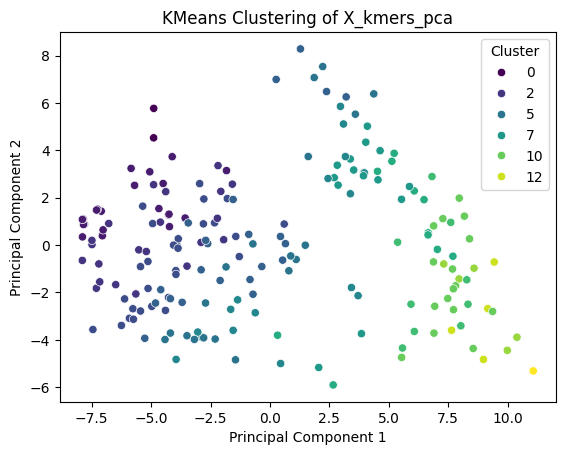

In [19]:
# Plot the clusters
fig, ax = plt.subplots()
sns.scatterplot(x=X_kmers_pca[:, 0], y=X_kmers_pca[:, 1], hue=X_kmers['A'].values, palette='viridis', ax=ax)
ax.set_title('KMeans Clustering of X_kmers_pca')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

We can also do this by looking at the features that are most important for classifying the clusters.

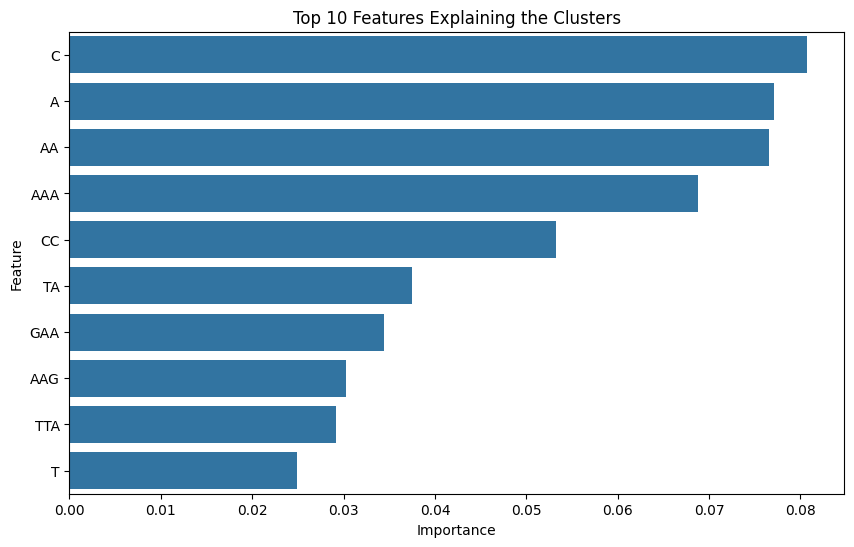

In [20]:
importances = RandomForestClassifier(random_state=42).fit(X_kmers, clusters).feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({'Feature': X_kmers.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Features Explaining the Clusters')
plt.show()

# Predictability analysis

In [21]:
X_train, X_test, y_train, y_test = dataset.split(split_strategy="random", random_state=42)
featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

model = RandomForestModel(task="regression")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
metrics_train = regression_metrics(y_train, y_pred_train)
metrics = regression_metrics(y_test, y_pred)
print(metrics_train)
print(metrics)


{'r2_score': 0.8987855069992001, 'root_mean_squared_error': 0.3208697901364699, 'mean_absolute_error': 0.2543607843137254, 'pearson_correlation': 0.9711217554133487, 'spearman_correlation': 0.9686302637028751}
{'r2_score': 0.151170590078874, 'root_mean_squared_error': 0.884847634718354, 'mean_absolute_error': 0.7413205128205126, 'pearson_correlation': 0.48612807021363896, 'spearman_correlation': 0.44111544162975824}


In [22]:
X_train, X_test, y_train, y_test = dataset_tlr8.split(split_strategy="random", random_state=42)
featurizer = KMersCounts(k=[1, 2, 3])
X_train = featurizer.fit_transform(X_train)
X_test = featurizer.transform(X_test)

model = RandomForestModel(task="regression")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
metrics_train = regression_metrics(y_train, y_pred_train)
metrics = regression_metrics(y_test, y_pred)
print(metrics_train)
print(metrics)


{'r2_score': 0.8652972681981642, 'root_mean_squared_error': 8.691556734788781, 'mean_absolute_error': 6.634463398692808, 'pearson_correlation': 0.9692088842262568, 'spearman_correlation': 0.9569854373231871}
{'r2_score': -0.024211357593851623, 'root_mean_squared_error': 20.643095275940052, 'mean_absolute_error': 17.618294871794873, 'pearson_correlation': 0.2549490244189917, 'spearman_correlation': 0.1536437246963563}


## Recommendation for dataset

These two datasets, with the same sequences but different end points, are very small with only 192 sequences. No clear patterns were found in the clustering analysis. The predictability analysis showed that the labels are not easy to predict on the test set, but a model trained on KMers only still performs better than chance. 